#### Import all libaries

In [2]:
!pip install wordcloud
# import libaries for data handling
import pandas as pd
import numpy as np
#import libaries for text cleaning
import re
#import for plotting
import matplotlib.pyplot as plt
#import for counting words frequence
from collections import Counter
#import for wordcloud 
from wordcloud import WordCloud

In [4]:
#Load the dataset CSV file into a pandas dataframe 
df=pd.read_csv("DisasterTweets.csv")
OUT_PATH  = "DisasterTweet_Classification/DisasterTweets_Preprocessed.csv"
print('Shape:', df.shape)
df.head()

Shape: (2559, 13)


,Name,UserName,Timestamp,Verified,Tweets,Comments,Retweets,Likes,Impressions,Tags,Tweet Link,Tweet ID,Disaster
0,Drought Center,@DroughtCenter,2024-02-29T13:30:07.000Z,False,US Drought Monitor 2-29-24\n\nHappy Leap Day! ...,0,17,13,18000,"['#droughtmonitor', '#drought', '#drought2024'...",https://twitter.com/DroughtCenter/status/17631...,1.760000e+18,Non-Disaster
1,Prabhakar Goud Kurmimdla,@PrabhakarGoud_K,2024-02-27T05:20:43.000Z,False,Synonym is #Drought,0,0,1,13,['#Drought'],https://twitter.com/PrabhakarGoud_K/status/176...,1.760000e+18,Non-Disaster
2,Humanity First International,@HFI1995,2024-03-03T07:03:34.000Z,False,"Across South America in the last two months, #...",0,9,19,419,"['#floods', '#landslides', '#drought', '#wildf...",https://twitter.com/HFI1995/status/17641848294...,1.760000e+18,Disaster
3,NCWQ Worldwide News And Disasters Explorer,@RTheExplorer1,2024-02-29T10:20:18.000Z,False,Wildfires Going On In Texas #wildfires #texa...,0,0,1,34,"['#wildfires', '#texasfires']",https://twitter.com/RTheExplorer1/status/17631...,1.760000e+18,Disaster
4,BestDealsEver,@MilwaukeeHotBuy,2024-02-28T17:58:01.000Z,False,START YOUR STAND UP COMEDY CAREER FOR $11.99 ...,0,0,0,210,"['#thevoice', '#rhonj', '#taylorswift', '#mia'...",https://twitter.com/MilwaukeeHotBuy/status/176...,1.760000e+18,Non-Disaster


In [6]:
#Checkig which columns have missing values
print("Missing values:")
print(df.isna().sum().sort_values(ascending=False))

Missing values:
Name           1
UserName       0
Timestamp      0
Verified       0
Tweets         0
Comments       0
Retweets       0
Likes          0
Impressions    0
Tags           0
Tweet Link     0
Tweet ID       0
Disaster       0
dtype: int64


#### Data checks


In [9]:
#Keep only two columns needed for this classification 
#remove rows with missing tweets or disaster labels
df = df[['Tweets','Disaster']].dropna()
df.head()

,Tweets,Disaster
0,US Drought Monitor 2-29-24\n\nHappy Leap Day! ...,Non-Disaster
1,Synonym is #Drought,Non-Disaster
2,"Across South America in the last two months, #...",Disaster
3,Wildfires Going On In Texas #wildfires #texa...,Disaster
4,START YOUR STAND UP COMEDY CAREER FOR $11.99 ...,Non-Disaster


In [11]:
#Convert string labels into numeric labels so model can use them 
df = df[['Tweets', 'Disaster']].dropna()

# Encode labels
df['Disaster_Label'] = df['Disaster'].map({
    'Disaster': 1,
    'Non-Disaster': 0
})

#Check class distribution
print("\nLabel count:")
print(df['Disaster_Label'].value_counts())


Label count:
Disaster_Label
1    1806
0     753
Name: count, dtype: int64


#### Class distribution

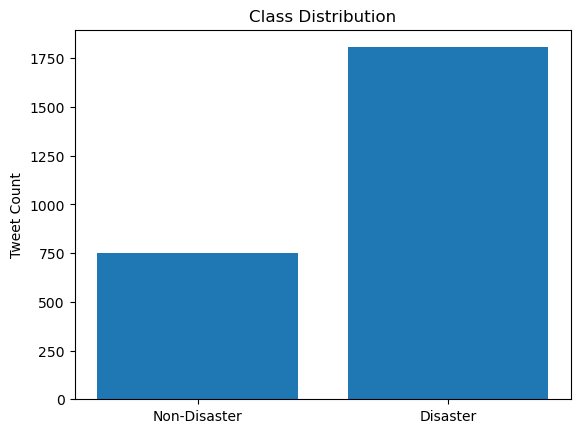

In [14]:
#Plot how many tweets belong to each class
counts = df['Disaster_Label'].value_counts()

plt.bar(['Non-Disaster', 'Disaster'], [counts[0], counts[1]])
plt.title("Class Distribution")
plt.ylabel("Tweet Count")
plt.show()

#### Clean tweet text

In [17]:
#Preprocessing: lowercase, remove URLS, remove non-letters, remove extra spaces
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)     # remove links
    text = re.sub(r"[^a-z\s]", "", text)    # remove symbols
    text = re.sub(r"\s+", " ", text).strip()
    return text

#Apply cleaning to Tweets column
df['clean_text'] = df['Tweets'].apply(clean_text)

df[['Tweets', 'clean_text']].head()

,Tweets,clean_text
0,US Drought Monitor 2-29-24\n\nHappy Leap Day! ...,us drought monitor happy leap day for the stat...
1,Synonym is #Drought,synonym is drought
2,"Across South America in the last two months, #...",across south america in the last two months fl...
3,Wildfires Going On In Texas #wildfires #texa...,wildfires going on in texas wildfires texasfires
4,START YOUR STAND UP COMEDY CAREER FOR $11.99 ...,start your stand up comedy career for purchase...


#### Tweet Length analysis


Average word length:
Disaster_Label
0    21.958831
1    21.500000
Name: word_len, dtype: float64


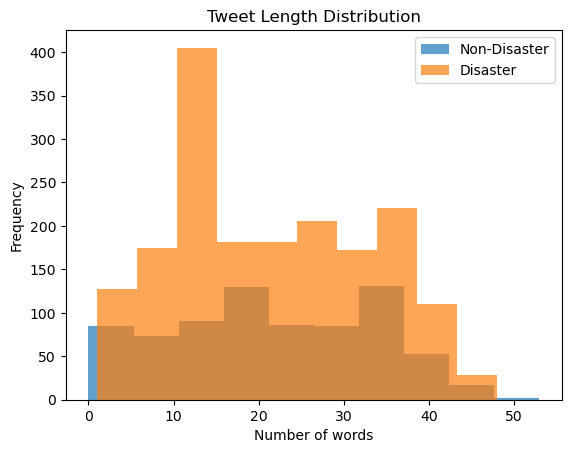

In [20]:
#Calculate number of words in each tweet
df['word_len'] = df['clean_text'].str.split().apply(len)

#compare average length between Disaster and Non-disaster tweets
print("\nAverage word length:")
print(df.groupby('Disaster_Label')['word_len'].mean())

#Plot length distribution for both class
plt.hist(df[df['Disaster_Label']==0]['word_len'], alpha=0.7, label='Non-Disaster')
plt.hist(df[df['Disaster_Label']==1]['word_len'], alpha=0.7, label='Disaster')
plt.legend()
plt.title("Tweet Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

#### Word Cloud for disaster vs Non-Disaster

In [33]:
def show_wordcloud(text, title):
#Creates and displays a word cloud safely using PIL image
    wc = WordCloud(width=1000, height=500, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc.to_image())   
    plt.axis("off")
    plt.title(title)
    plt.show()


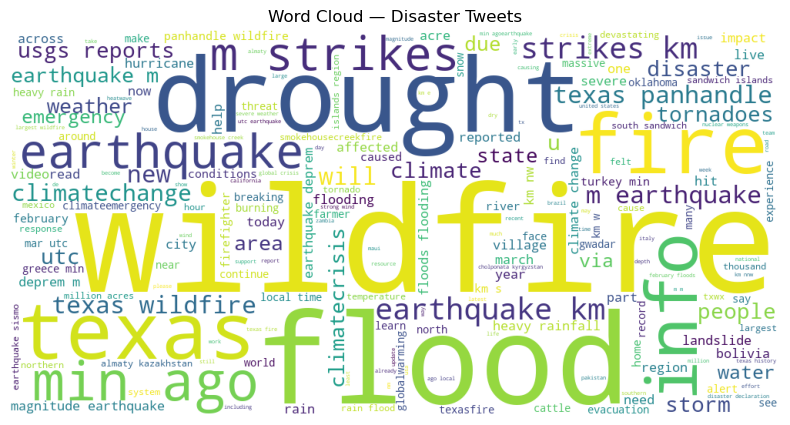

In [35]:
# Combine all disaster tweets into one big text
disaster_text = " ".join(df[df["Disaster_Label"] == 1]["clean_text"])

show_wordcloud(disaster_text, "Word Cloud — Disaster Tweets")


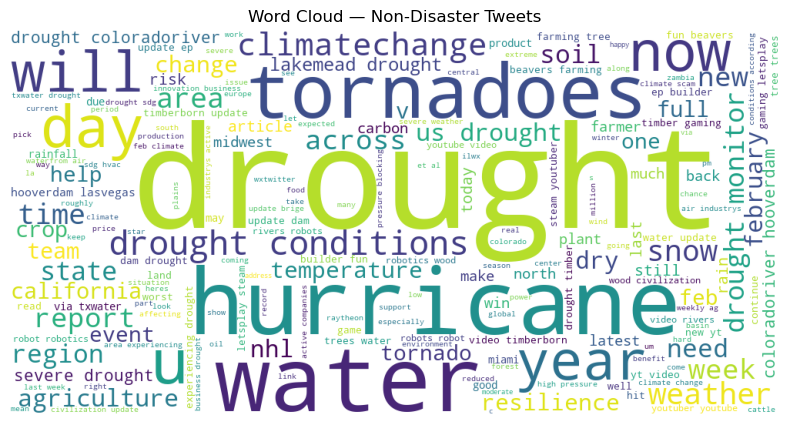

In [37]:
# Combine all non-disaster tweets into one big text
non_disaster_text = " ".join(df[df["Disaster_Label"] == 0]["clean_text"])

show_wordcloud(non_disaster_text, "Word Cloud — Non-Disaster Tweets")


#### Most frequent words

Top 15 most frequent words (overall):
[('the', 2169), ('of', 1335), ('in', 1237), ('to', 1071), ('and', 990), ('drought', 904), ('a', 762), ('wildfires', 643), ('earthquake', 522), ('floods', 518), ('is', 485), ('for', 471), ('on', 438), ('texas', 399), ('more', 346)]


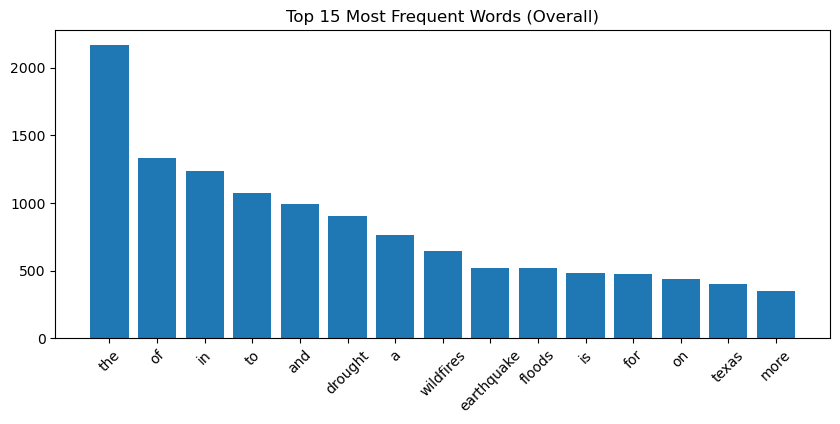

In [40]:
# Split all cleaned text into words and count frequency
all_words = " ".join(df["clean_text"]).split()
common_words = Counter(all_words).most_common(15)

print("Top 15 most frequent words (overall):")
print(common_words)

# Plot top words
words = [w for w, c in common_words]
counts = [c for w, c in common_words]

plt.figure(figsize=(10, 4))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 15 Most Frequent Words (Overall)")
plt.show()


#### Most repeated words

Top words in Disaster tweets: [('the', 1501), ('of', 988), ('in', 857), ('and', 717), ('to', 699), ('wildfires', 643), ('a', 533), ('earthquake', 522), ('floods', 518), ('texas', 395), ('on', 317), ('for', 312), ('is', 311), ('km', 304), ('drought', 303)]
Top words in Non-Disaster tweets: [('the', 668), ('drought', 601), ('in', 380), ('to', 372), ('of', 347), ('and', 273), ('a', 229), ('is', 174), ('water', 164), ('for', 159), ('hurricanes', 144), ('on', 121), ('this', 94), ('from', 88), ('with', 86)]


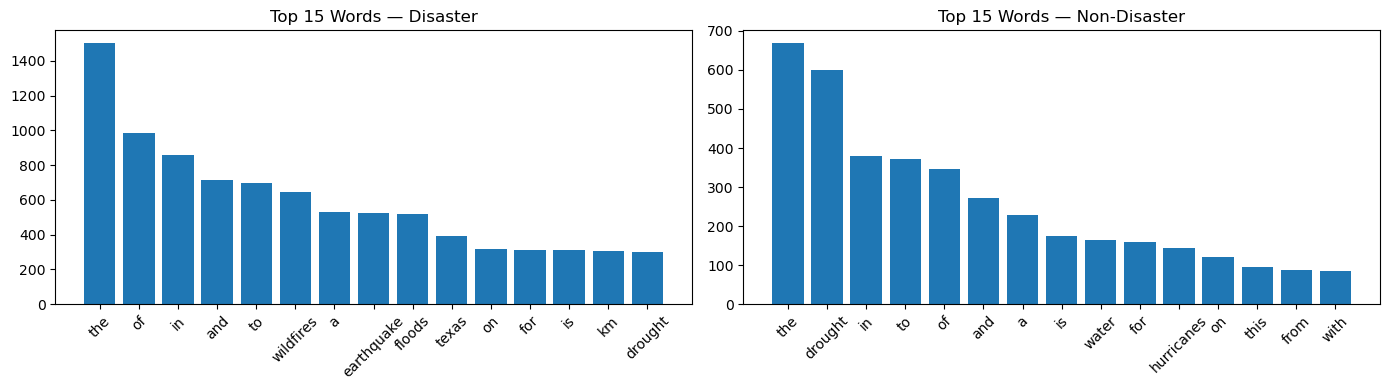

In [42]:
def top_words(text_series, top_n=15):
    words = " ".join(text_series).split()
    return Counter(words).most_common(top_n)

# Top words per class
top_disaster = top_words(df[df["Disaster_Label"] == 1]["clean_text"], 15)
top_non_disaster = top_words(df[df["Disaster_Label"] == 0]["clean_text"], 15)

print("Top words in Disaster tweets:", top_disaster)
print("Top words in Non-Disaster tweets:", top_non_disaster)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Disaster
words_d = [w for w, c in top_disaster]
counts_d = [c for w, c in top_disaster]
axes[0].bar(words_d, counts_d)
axes[0].set_title("Top 15 Words — Disaster")
axes[0].tick_params(axis="x", rotation=45)

# Non-disaster
words_n = [w for w, c in top_non_disaster]
counts_n = [c for w, c in top_non_disaster]
axes[1].bar(words_n, counts_n)
axes[1].set_title("Top 15 Words — Non-Disaster")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


#### save preprocessed data

In [44]:
# Save the preprocessed dataframe (df) to CSV
df.to_csv(OUT_PATH, index=False)

print("✅ Preprocessed file saved at:", OUT_PATH)
print("Processed data shape:", df.shape)

df.head()


✅ Preprocessed file saved at: disaster_tweets_preprocessed.csv
Processed data shape: (2559, 5)


,Tweets,Disaster,Disaster_Label,clean_text,word_len
0,US Drought Monitor 2-29-24\n\nHappy Leap Day! ...,Non-Disaster,0,us drought monitor happy leap day for the stat...,35
1,Synonym is #Drought,Non-Disaster,0,synonym is drought,3
2,"Across South America in the last two months, #...",Disaster,1,across south america in the last two months fl...,29
3,Wildfires Going On In Texas #wildfires #texa...,Disaster,1,wildfires going on in texas wildfires texasfires,7
4,START YOUR STAND UP COMEDY CAREER FOR $11.99 ...,Non-Disaster,0,start your stand up comedy career for purchase...,23
